![title](img/neural_network.png)

### Initial setup
##### Neural Network Inference
Propagate input signal (i.e. images with cats) through layers of neurons to output (usually) some class.
Each neuron computes a weighted sum of the neurons in the previous layer and, if the sum passes a threshold, it is activated.

https://playground.tensorflow.org/

##### Neural Network Training:
    1. Compute "error" function (i.e. the difference between what is predicted and the truth).
    2. Compute the derivative of the error function with respect to the weights of each neuron (how each parameter contributed to the error).
    3. Make a small update on the weights so as to minimize the error function.



##### Tensorflow helps with:
    1. Multipling matrices during inference
    2. Taking derivatives during trainig
   
##### Steps:

    1. Create a data-flow graph.
    2. Create a session.
    3. Access the graph through the session.

In [2]:
#The usual imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

### Prepare data

(60000, 28, 28) (60000, 10) (10000, 28, 28) (10000, 10)


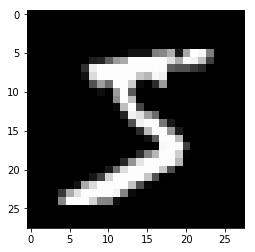

In [3]:
def transform_labels(numerical_labels):
    #use one hot encoding of labels instead of numeric
    #e.g. 2 will become [0,0,1,0,0,0,...]
    categorical = np.zeros((len(numerical_labels),10))
    for idx,label in enumerate(numerical_labels):
        categorical[idx][label] = 1
    return categorical


#Load mnist (the "hello world" of machine learning)
(train_img,train_label),(test_img,test_label) = tf.keras.datasets.mnist.load_data()
plt.imshow(train_img[0],cmap='gray')

train_label = transform_labels(train_label)
test_label  = transform_labels(test_label)
print (train_img.shape,train_label.shape,test_img.shape,test_label.shape)

### Define the dataflow 

In [4]:

#Inputs in the dataflow graph
image_input = tf.placeholder(tf.float32,shape=(None,28,28))
label_input = tf.placeholder(tf.int16,shape=(None,10))

#Define parameters; initially they are random; they will be learned
weights = tf.get_variable("weights",
                          shape=[28*28,10],
                          dtype=tf.float32,
                          initializer=tf.random_normal_initializer(),
                         )

bias    = tf.get_variable("bias",
                          shape=[1],
                          dtype=tf.float32,
                          initializer=tf.constant_initializer(0))

#Transform the input matrix from a 2d array into a 1d array
#Multiply the reshaped image with the weights and add the bias

predicted_logits = tf.matmul(tf.reshape(image_input,shape=(-1,28*28)),weights)+bias

#Compute the error
#Transform the output into probabilities and compare the obtained distribution with the desired distribution
#https://deepnotes.io/softmax-crossentropy for the curious

error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_logits,labels=label_input))

#Define the optimizer; this is the thing that actually minimizez the error;
#It looks at all the variables that contribute to the error and adjusts them 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(error)

#Record the error for tensorboard
#During training we run "tensorboard --logdir=/path/to/logs""

error_summary = tf.summary.scalar('average_error', error) 
#We need to ru this in order to initialize the variables
init = tf.global_variables_initializer()

#At this point the blueprint is created. 

### Perform the training

In [5]:
#How many passes through the data should we do
num_epochs = 10
#How many images at once
batch_size  = 32

with tf.Session() as sess:
    #Initialize the weights and bias
    sess.run(init)
    #Define the model saver. We will subsequently load the model in order to use it.
    saver = tf.train.Saver()
    
    #Define the actual tensorboard logger
    summary_writter = tf.summary.FileWriter('./mnist_training_summary',sess.graph)

    #At each passing you want to feed the data in a different order
    read_order = np.arange(len(train_img))
    batch_idx = 0
    
    #Let's see what we get when we just use the random weights
    logits,test_loss = sess.run([predicted_logits,error],feed_dict={
                image_input:test_img,
                label_input:test_label
            })
    print("Initial number of errors: {}".format(np.count_nonzero(np.argmax(logits,axis=1)-np.argmax(test_label,axis=1))))
    
    for epoch in range(num_epochs):
        
        #Feed images, get predictions, apply gradients - all just by running "optimizer" operation
        while batch_idx+batch_size<len(train_img): 
            _,summary = sess.run([optimizer,error_summary],feed_dict={
                image_input:train_img[read_order[batch_idx:batch_idx+batch_size]],
                label_input:train_label[read_order[batch_idx:batch_idx+batch_size]]
            })
            batch_idx+=batch_size
            
            #Log the error at the current training step in order to be visualised in tensorboard
            training_step = len(train_img)/batch_size*epoch+batch_idx/batch_size
            summary_writter.add_summary(summary,training_step) 
        
        #Test the model after each epoch
        logits,test_loss = sess.run([predicted_logits,error],feed_dict={
                image_input:test_img,
                label_input:test_label
            })
        
        print("Number  of errors after epoch {} is: {}".format(epoch,np.count_nonzero(np.argmax(logits,axis=1)-np.argmax(test_label,axis=1))))
        
        #Save the model after each epoch
        saver.save(sess, './mnist_model',global_step=epoch)
        
        #Prepare for the next epoch; need to shuffle the data and reset the index
        np.random.shuffle(read_order)
        batch_idx=0
        #For cooler ways to handle the data google "tf.data" 

Initial number of errors: 9058
Number  of errors after epoch 0 is: 1349
Number  of errors after epoch 1 is: 1213
Number  of errors after epoch 2 is: 1178
Number  of errors after epoch 3 is: 1217
Number  of errors after epoch 4 is: 1217
Number  of errors after epoch 5 is: 1116
Number  of errors after epoch 6 is: 1155
Number  of errors after epoch 7 is: 1177
Number  of errors after epoch 8 is: 1198
Number  of errors after epoch 9 is: 1147


### Restore the saved model

In [6]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("./mnist_model-9.meta")
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    logits,test_loss = sess.run([predicted_logits,error],feed_dict={
                image_input:test_img,
                label_input:test_label
            })
        
    print("Final number of errors is: {}".format(np.count_nonzero(np.argmax(logits,axis=1)-np.argmax(test_label,axis=1))))
        

INFO:tensorflow:Restoring parameters from ./mnist_model-9
Final number of errors is: 1147


# Exercises

##### Modify the above code to:
1. Actually create a neural network: add 1 hidden layer with 512 neurons. Use sigmoid activation.
2. Change the activation function to relu
3. Add l2 regularization.
4. Trace each component of the error and the test accuracy (in %) in tensorboard. 
5. Add dropout
6. Go deeper with the layers
7. And deeper
8. ... you get the idea